In [1]:
import sys

import matplotlib
import numpy as np
import xarray as xr

climate_indices_home_path = "/home/james/git/climate_indices"
if climate_indices_home_path not in sys.path:
    sys.path.append(climate_indices_home_path)
from climate_indices import compute, indices, utils

%matplotlib inline

/home/james/miniconda3/envs/climate/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
ds = xr.open_dataset("/home/james/data/nclimgrid/nclimgrid_lowres_prcp.nc")

In [3]:
precip_var_name = "prcp"

In [4]:
da_prcp = ds[precip_var_name].transpose('lat', 'lon', 'time')

In [5]:
initial_year = int(da_prcp['time'][0].dt.year)
calibration_year_initial = 1900
calibration_year_final = 2000
period_times = 12
total_lats = da_prcp.shape[0]
total_lons = da_prcp.shape[1]
fitting_shape = (total_lats, total_lons, period_times)
scale = 3

In [6]:
%%time
alphas = np.full(shape=fitting_shape, fill_value=np.NaN)
betas = np.full(shape=fitting_shape, fill_value=np.NaN)
spi = np.full(shape=da_prcp.shape, fill_value=np.NaN)
for lat_index in range(total_lats):
    for lon_index in range(total_lons):

        # get the values for the lat/lon grid cell
        values = da_prcp[lat_index, lon_index]

        # skip over this grid cell if all NaN values
        if (np.ma.is_masked(values) and values.mask.all()) or np.all(np.isnan(values)):
            continue

        # convolve to scale
        scaled_values = \
            compute.scale_values(
                values,
                scale=scale,
                periodicity=compute.Periodicity.monthly,
            )

        # compute the fitting parameters on the scaled data
        alphas[lat_index, lon_index], betas[lat_index, lon_index] = \
            compute.gamma_parameters(
                scaled_values,
                data_start_year=initial_year,
                calibration_start_year=calibration_year_initial,
                calibration_end_year=calibration_year_final,
                periodicity=compute.Periodicity.monthly,
            )
        gamma_parameters = {
            "alphas": alphas[lat_index, lon_index],
            "betas": betas[lat_index, lon_index],
        }
        
        # compute the SPI
        spi[lat_index, lon_index] = \
            indices.spi(
                values,
                scale=scale,
                distribution=indices.Distribution.gamma,
                data_start_year=initial_year,
                calibration_year_initial=calibration_year_initial,
                calibration_year_final=calibration_year_final,
                periodicity=compute.Periodicity.monthly,
                fitting_params=gamma_parameters,
            )

CPU times: user 26min 7s, sys: 25.8 s, total: 26min 33s
Wall time: 26min 34s


In [7]:
spi_var_name = f"spi_gamma_{str(scale).zfill(2)}"

In [8]:
ds_spi = xr.Dataset(
    {
        spi_var_name: (da_prcp.dims, spi),
    },
    coords=da_prcp.coords,
)

In [33]:
ds_spi[spi_var_name].attrs = {
    'valid_min': -3.09,
    'valid_max': 3.09,
    'long_name': f'{scale}-month SPI(gamma)',
    'calibration_year_initial': calibration_year_initial,
    'calibration_year_final': calibration_year_final,
}

In [10]:
ds_spi

<xarray.Dataset>
Dimensions:       (lat: 38, lon: 87, time: 1466)
Coordinates:
  * lat           (lat) float32 24.5625 25.229166 ... 48.5625 49.229168
  * lon           (lon) float32 -124.6875 -124.020836 ... -68.020836 -67.354164
  * time          (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2017-02-01
Data variables:
    spi_gamma_03  (lat, lon, time) float64 nan nan nan nan ... nan nan nan nan

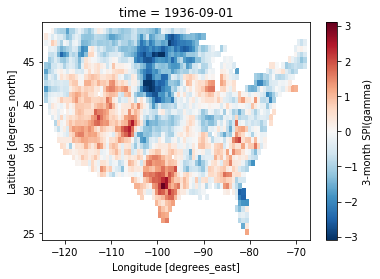

In [34]:
ds_spi[spi_var_name].isel(time=500).plot()

In [35]:
alpha_var_name = f"alpha_{str(scale).zfill(2)}"
beta_var_name = f"beta_{str(scale).zfill(2)}"

In [36]:
ds_gammas = xr.Dataset(
    {
        alpha_var_name: (("lat", "lon", "month"), alphas),
        beta_var_name: (("lat", "lon", "month"), betas),
    },
    coords={"lat": ds.lat, "lon": ds.lon, "month": range(12)},
)

In [30]:
ds_gammas

<xarray.Dataset>
Dimensions:   (lat: 38, lon: 87, month: 12)
Coordinates:
  * lat       (lat) float32 24.5625 25.229166 25.895834 ... 48.5625 49.229168
  * lon       (lon) float32 -124.6875 -124.020836 ... -68.020836 -67.354164
  * month     (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    alpha_03  (lat, lon, month) float64 nan nan nan nan nan ... nan nan nan nan
    beta_03   (lat, lon, month) float64 nan nan nan nan nan ... nan nan nan nan

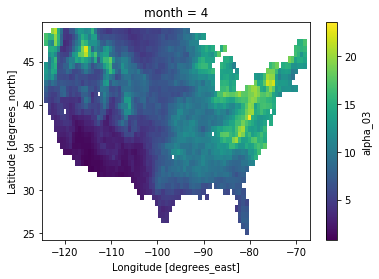

In [32]:
ds_gammas[alpha_var_name].isel(month=4).plot()

In [39]:
attrs_to_copy = [
    'Conventions',
    'ncei_template_version',
    'naming_authority',
    'standard_name_vocabulary',
    'institution',
    'geospatial_lat_min',
    'geospatial_lat_max',
    'geospatial_lon_min',
    'geospatial_lon_max',
    'geospatial_lat_units',
    'geospatial_lon_units',
]
global_attrs = {key: value for (key, value) in ds.attrs.items() if key in attrs_to_copy}
ds_spi.attrs = global_attrs
ds_gammas.attrs['description'] = f'SPI (gamma distribution) computed from monthly precipitation ' + \
    f'data for the period {ds.time[0]} through {ds.time[-1]} using a calibration period ' + \
    f'from {calibration_year_initial} through {calibration_year_final}'
ds_gammas.attrs = global_attrs
ds_gammas.attrs['description'] = f'Gamma distribution fitting parameters computed from monthly ' + \
    f'precipitation data for the period {ds.time[0]} through {ds.time[-1]} using a calibration period ' + \
    f'from {calibration_year_initial} through {calibration_year_final}'

In [40]:
ds_gammas

<xarray.Dataset>
Dimensions:   (lat: 38, lon: 87, month: 12)
Coordinates:
  * lat       (lat) float32 24.5625 25.229166 25.895834 ... 48.5625 49.229168
  * lon       (lon) float32 -124.6875 -124.020836 ... -68.020836 -67.354164
  * month     (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    alpha_03  (lat, lon, month) float64 nan nan nan nan nan ... nan nan nan nan
    beta_03   (lat, lon, month) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    naming_authority:          gov.noaa.ncei
    standard_name_vocabulary:  Standard Name Table v35
    institution:               National Centers for Environmental Information...
    geospatial_lat_min:        24.5625
    geospatial_lat_max:        49.354168
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      

In [ ]:
ds_gammas[alpha_var_name].attrs = {
    'description': 'shape parameter of the gamma distribution (also referred to as the concentration) ' + \
        f'computed from the {scale}-month scaled precipitation values',
}
ds_gammas[beta_var_name].attrs = {
    'description': '1 / scale of the distribution (also referred to as the rate) ' + \
        f'computed from the {scale}-month scaled precipitation values',
}

In [19]:
ds_gammas

<xarray.Dataset>
Dimensions:  (lat: 38, lon: 87, month: 12)
Coordinates:
  * lat      (lat) float32 24.5625 25.229166 25.895834 ... 48.5625 49.229168
  * lon      (lon) float32 -124.6875 -124.020836 ... -68.020836 -67.354164
  * month    (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    alpha    (lat, lon, month) float64 nan nan nan nan nan ... nan nan nan nan
    beta     (lat, lon, month) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    naming_authority:          gov.noaa.ncei
    standard_name_vocabulary:  Standard Name Table v35
    institution:               National Centers for Environmental Information...
    geospatial_lat_min:        24.5625
    geospatial_lat_max:        49.354168
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degree

In [42]:
ds_gammas[alpha_var_name]

<xarray.DataArray 'alpha_03' (lat: 38, lon: 87, month: 12)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * lat      (lat) float32 24.5625 25.229166 25.895834 ... 48.5625 49.229168
  * lon      (lon) float32 -124.6875 -124.020836 ... -68.020836 -67.354164
  * month    (month) int64 0 1 2 3 4 5 6 7 8 9 10 11

Write the gamma fitting parameters Dataset to NetCDF.

In [43]:
netcdf_gamma = '/home/james/data/nclimgrid/nclimgrid_lowres_gamma.nc'

In [48]:
ds_gammas.to_netcdf(netcdf_gamma)

Read the gamma fitting parameters NetCDF into a new Dataset.

In [49]:
ds_gamma = xr.open_dataset(netcdf_gamma)
ds_gamma

Recompute the SPI using the pre-computed fitting parameters read from NetCDF.

In [ ]:
%%time
for lat_index in range(total_lats):
    for lon_index in range(total_lons):

        # get the values for the lat/lon grid cell
        values = da_prcp[lat_index, lon_index]

        # skip over this grid cell if all NaN values
        if (np.ma.is_masked(values) and values.mask.all()) or np.all(np.isnan(values)):
            continue

        # convolve to scale
        scaled_values = \
            compute.scale_values(
                values,
                scale=scale,
                periodicity=compute.Periodicity.monthly,
            )

        # get the fitting parameters on the scaled data
        alphas[lat_index, lon_index], betas[lat_index, lon_index] = \
            compute.gamma_parameters(
                scaled_values,
                data_start_year=initial_year,
                calibration_start_year=calibration_year_initial,
                calibration_end_year=calibration_year_final,
                periodicity=compute.Periodicity.monthly,
            )
        gamma_parameters = {
            "alphas": ds_gamma[alpha_var_name][lat_index, lon_index],
            "betas": ds_gamma[beta_var_name][lat_index, lon_index],
        }
        
        # compute the SPI
        spi[lat_index, lon_index] = \
            indices.spi(
                values,
                scale=scale,
                distribution=indices.Distribution.gamma,
                data_start_year=initial_year,
                calibration_year_initial=calibration_year_initial,
                calibration_year_final=calibration_year_final,
                periodicity=compute.Periodicity.monthly,
                fitting_params=gamma_parameters,
            )